In [1]:
# just imports
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split

In [2]:
# local imports
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset, get_datasets
from VAE.loss_funcs import VAE_Loss
from VAE import vae_models

In [3]:
import pickle
unlrg_data_set = pickle.load( open( "unlrg.p", "rb" ) )
lrg_datasets   = pickle.load( open( "lrg.p", "rb" ) )

In [4]:
batch_size = 16 #supposedly low batch size helps fater convergence

data_loader_lrg       = data.DataLoader(lrg_datasets['full'], batch_size=128, shuffle=False)
data_loader_lrg_train = data.DataLoader(lrg_datasets['train'], batch_size=256, shuffle=True)
data_loader_lrg_test  = data.DataLoader(lrg_datasets['test'],  batch_size=256, shuffle=True)
data_loader_unlrg     = data.DataLoader(unlrg_data_set, batch_size=16,  shuffle=True)

sample = iter(data_loader_lrg).next()

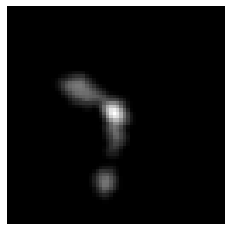

In [5]:
plt.imshow(sample[0][1][0], cmap='gray')
plt.axis('off')
plt.show()

In [6]:
sample[1]

tensor([4, 3, 2, 2, 0, 4, 4, 1, 3, 1, 3, 3, 2, 1, 4, 4, 3, 3, 3, 0, 0, 1, 3, 0,
        4, 2, 3, 1, 1, 1, 4, 4, 4, 0, 1, 0, 3, 4, 3, 3, 4, 3, 3, 1, 1, 3, 4, 3,
        3, 5, 0, 3, 3, 0, 2, 5, 5, 3, 4, 3, 3, 1, 3, 1, 3, 0, 3, 3, 5, 0, 1, 3,
        3, 1, 0, 2, 3, 3, 3, 3, 2, 1, 0, 1, 2, 2, 3, 0, 0, 2, 1, 2, 2, 3, 1, 3,
        3, 4, 5, 0, 3, 1, 2, 2, 4, 2, 2, 1, 3, 1, 1, 3, 3, 2, 3, 3, 1, 1, 3, 2,
        1, 1, 2, 0, 4, 2, 0, 3])

In [7]:
class VAE(nn.Module):
    def __init__(self, lt_dim=4, k=None, batch_norm=True, n_classes=2):
        super(VAE, self).__init__()
        self.k = k
        n_layers = len(self.k)
        encoder_layers = []
        decoder_layers = []
        
        for i in range( n_layers -1) :
            in_c, out_c = self.k[i], self.k[i + 1]
            if(in_c == 'M'): continue
            stride = 1
            if out_c == 'M':
                stride = 2
                i += 1
                out_c = self.k[i + 1]
            layer = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
            encoder_layers.append(layer)
            if batch_norm:
                encoder_layers.append(nn.BatchNorm2d(out_c))
            encoder_layers.append(nn.ReLU(inplace=True))
        self.encoder = nn.Sequential(*encoder_layers)
        
        for i in range(n_layers - 1, 0, -1):
            in_c, out_c = self.k[i], self.k[i - 1]
            if(in_c == 'M'): continue
            stride = 1
            output_padding=0
            if out_c == 'M':
                stride = 2
                i -= 1
                out_c = self.k[i - 1]
                output_padding=1
                
            layer = nn.ConvTranspose2d(in_c, out_c, kernel_size=3, padding=1, 
                                       output_padding=output_padding, stride=stride)
            decoder_layers.append(layer)
            if batch_norm:
                decoder_layers.append(nn.BatchNorm2d(out_c))
            decoder_layers.append(nn.ReLU(inplace=True))

        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        self.fc_ep = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
        
        #simple classifier bit
        self.classifier = nn.Sequential(
            nn.Linear(lt_dim, n_classes),
        )
        
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if self.training :
            return mu + eps*std
        return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x))
        x = x.view(-1, self.k[-1], 2, 2) #reshape
        return torch.sigmoid(self.decoder(x))
    
    def classify(self, x):
        y = self.classifier(x)
        return F.softmax(y)
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        y = self.classify(z)
        return d, mu, var, y

In [8]:
def train_step_vae(mode, device, data_loader, optim, epoch, loss_fun, log_interval=5, beta=1):
    model.train()
    s = ''
    r_loss = 0
    batch_sum = 0
    avg_r_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        data = data.to(device)
        target = Variable(data, requires_grad=False).to(device)
        #Forward Pass
        optim.zero_grad()
        d, mu, var, y = model(data)
        output = (d, mu, var)

        # BCE Loss
        r_loss, g_loss = loss_fun(output, data)
        
        loss = r_loss + (beta * g_loss)
        avg_r_loss += r_loss.item()
        #Backpropagation
        loss.backward()
        optim.step()
        s = 'Train Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)]\tLoss: {:4.4f}\tR_Loss: {:4.4f}\tDKL: {:4.4f}'
        s = s.format(epoch, batch_sum, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()/len(data),
                     r_loss.item()/len(data), g_loss.item()/len(data))
        
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
#     print('')
    return s, avg_r_loss / batch_sum

In [9]:
def get_compact_v_extended_loss(y, target):
    target = 1*(target > 0)
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = y[:,0]
    y2[:,1] = torch.sum(y[:,1:], dim=1)
    c_loss = criterion(y2, 1*(target > 0))
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y)
    return c_loss, acc

def get_fr1_v_fr2_loss(y, target):
    tipical = (target == 2) + (target == 1)
    target = target[tipical]
    target = 1*(target == 2)
    
    y = y[tipical]
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = y[:,1] / torch.sum(y[:,1:3], dim=1)
    y2[:,1] = y[:,2] / torch.sum(y[:,1:3], dim=1)

    c_loss = criterion(y2, target)
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y2)
    return c_loss, acc

def get_tip_v_atip_loss(y, target):
    tipical = target  > 0
    target = target[tipical]
    target = 1*(target > 2)
    
    y = y[tipical]
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = torch.sum(y[:,1:3], dim=1) / torch.sum(y[:,1:], dim=1)
    y2[:,1] = torch.sum(y[:,3: ], dim=1) / torch.sum(y[:,1:], dim=1)

    c_loss = criterion(y2, target)
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y2)
    return c_loss, acc

def get_bent_v_irreg_loss(y, target):
    tipical = target  > 2
    target = target[tipical]
    target = 1*(target > 3)
    
    y = y[tipical]
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = y[:,3 ] / torch.sum(y[:,3:], dim=1)
    y2[:,1] = torch.sum(y[:,4:], dim=1) / torch.sum(y[:,3:], dim=1)

    c_loss = criterion(y2, 1*(target > 0))
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y2)
    return c_loss, acc

def get_r_v_x_loss(y, target):
    tipical = (target == 4) + (target == 5)
    target = target[tipical]
    target = 1*(target == 5)
    
    y = y[tipical]
    y2 = torch.zeros([y.shape[0], 2]).to(device)
    y2[:,0] = y[:,4] / torch.sum(y[:,4:], dim=1)
    y2[:,1] = y[:,5] / torch.sum(y[:,4:], dim=1)

    c_loss = criterion(y2, target)
    _, preds = torch.max(y2, 1)
    acc = (1.0*torch.sum(preds == target))/len(y2)
    return c_loss, acc

def classify_step_vae(mode, device, data_loader, optim, epoch, loss_fun, criterion, log_interval=5, beta=1):
    model.train()
    s = ''
    r_loss = 0
    batch_sum = 0
    avg_c_loss = 0
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        data = data.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optim.zero_grad()
        d, mu, var, y = model(data)
        output = (d, mu, var)
        
        # BCE Loss
        r_loss, g_loss = loss_fun(output, data)
        #Classify Loss
        c_loss, c_acc = get_compact_v_extended_loss(y, target)
        #fr1 v fr2 loss
        fr_loss, fr_acc = get_fr1_v_fr2_loss(y, target)
        #tip v atip loss
        t_loss, t_acc = get_tip_v_atip_loss(y, target)
        #bent v irreg loss
        b_loss, b_acc = get_bent_v_irreg_loss(y, target)
        #r v x loss
        rx_loss, rx_acc = get_r_v_x_loss(y, target)
        #Compund Loss
        #
        loss = r_loss + (beta * g_loss) #+ (8 * c_loss + 4*t_loss + 2*fr_loss + 2*b_loss + rx_loss)
        avg_c_loss += c_loss.item()
        #Backpropagation
        loss.backward()
        optim.step()
        # statistics
        running_loss += loss.item() / data.size(0)
#         running_corrects += torch.sum(preds == target.data)
#         running_inputs += len(target.data)
#         running_acc = (1.0 * running_corrects)/running_inputs
        
        s = 'Clasify Train Epoch: {:3d} ({:3.0f}%)\tC Acc: {:.4f}\tFR Acc: {:.4f}\tT Acc: {:.4f}\tB Acc: {:.4f}\tRX Acc: {:.4f}'
        s = s.format(epoch,
                100. * batch_idx / len(data_loader), c_acc, fr_acc,t_acc, b_acc,rx_acc)
        
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    print('')
    return s

In [10]:
def test_step_vae(model, device, data_loader, loss_fun, learn_rot=False):
    model.eval()
    avg_r_loss = 0
    batch_sum = 0 
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            d, mu, var, y = model(data)
            output = (d, mu, var)
            # BCE Loss
            r_loss , g_loss = loss_fun(output, data)
            avg_r_loss += r_loss.item()
            
    return avg_r_loss / batch_sum

In [11]:
device = 'cuda'
epochs = 40

Clasify Train Epoch:   1 ( 99%)	C Acc: 0.5132	FR Acc: 0.5000	T Acc: 0.5000	B Acc: 0.4706	RX Acc: 0.6190
Train Epoch:   1 [139800/139800 (100%)]	Loss: 22.3117	R_Loss: 22.2966	DKL: 0.0019	AvgR 56.4834	Test Loss : 2.0654   Time : 266.59s
Beta : 4.2870938501451725
Clasify Train Epoch:   2 ( 99%)	C Acc: 0.5461	FR Acc: 0.4091	T Acc: 0.6024	B Acc: 0.5128	RX Acc: 0.4286
Train Epoch:   2 [139800/139800 (100%)]	Loss: 15.3473	R_Loss: 15.0578	DKL: 0.0675	AvgR 6.9432	Test Loss : 1.0844   Time : 268.30s
Beta : 2.7702189362218492
Clasify Train Epoch:   3 ( 99%)	C Acc: 0.5461	FR Acc: 0.4884	T Acc: 0.3614	B Acc: 0.5000	RX Acc: 0.7143
Train Epoch:   3 [139800/139800 (100%)]	Loss: 7.8343	R_Loss: 7.4891	DKL: 0.1246	AvgR 4.2152	Test Loss : 0.9155   Time : 264.76s
Beta : 2.0406093184969154
Clasify Train Epoch:   4 ( 99%)	C Acc: 0.5197	FR Acc: 0.6341	T Acc: 0.3797	B Acc: 0.5000	RX Acc: 0.5000
Train Epoch:   4 [139800/139800 (100%)]	Loss: 8.3463	R_Loss: 7.6225	DKL: 0.3547	AvgR 3.4704	Test Loss : 0.8160   Time

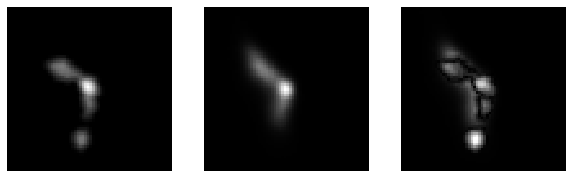

Clasify Train Epoch:  11 ( 99%)	C Acc: 0.5000	FR Acc: 0.5278	T Acc: 0.4868	B Acc: 0.4750	RX Acc: 0.5263
Train Epoch:  11 [139800/139800 (100%)]	Loss: 4.5432	R_Loss: 4.0928	DKL: 0.4247	AvgR 3.0462	Test Loss : 0.7707   Time : 255.80s
Beta : 1.041974377928387
Clasify Train Epoch:  12 ( 99%)	C Acc: 0.4934	FR Acc: 0.5000	T Acc: 0.3867	B Acc: 0.5161	RX Acc: 0.7333
Train Epoch:  12 [139800/139800 (100%)]	Loss: 3.6474	R_Loss: 3.3542	DKL: 0.2814	AvgR 3.0350	Test Loss : 0.7808   Time : 254.46s
Beta : 1.0292003562788727
Clasify Train Epoch:  13 ( 99%)	C Acc: 0.5263	FR Acc: 0.5349	T Acc: 0.5949	B Acc: 0.6111	RX Acc: 0.6111
Train Epoch:  13 [139800/139800 (100%)]	Loss: 8.0210	R_Loss: 7.4132	DKL: 0.5905	AvgR 3.0278	Test Loss : 0.7698   Time : 258.23s
Beta : 1.020351834207602
Clasify Train Epoch:  14 ( 99%)	C Acc: 0.4868	FR Acc: 0.4898	T Acc: 0.3973	B Acc: 0.6667	RX Acc: 0.5000
Train Epoch:  14 [139800/139800 (100%)]	Loss: 9.0415	R_Loss: 8.3490	DKL: 0.6787	AvgR 3.0214	Test Loss : 0.7508   Time : 259.

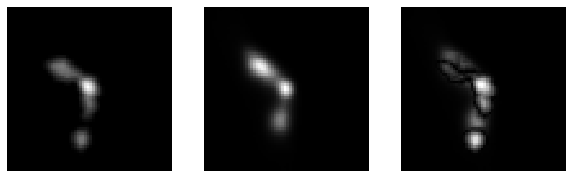

Clasify Train Epoch:  21 ( 99%)	C Acc: 0.5658	FR Acc: 0.4468	T Acc: 0.4535	B Acc: 0.5897	RX Acc: 0.4762
Train Epoch:  21 [139800/139800 (100%)]	Loss: 4.8356	R_Loss: 4.5004	DKL: 0.3346	AvgR 2.9931	Test Loss : 0.8090   Time : 256.77s
Beta : 1.0011621382326186
Clasify Train Epoch:  22 ( 99%)	C Acc: 0.5461	FR Acc: 0.5106	T Acc: 0.4146	B Acc: 0.5429	RX Acc: 0.5333
Train Epoch:  22 [139800/139800 (100%)]	Loss: 7.1936	R_Loss: 6.3821	DKL: 0.8106	AvgR 2.9870	Test Loss : 0.7881   Time : 257.02s
Beta : 1.000813355024846
Clasify Train Epoch:  23 ( 99%)	C Acc: 0.5197	FR Acc: 0.5405	T Acc: 0.4684	B Acc: 0.6190	RX Acc: 0.5000
Train Epoch:  23 [139800/139800 (100%)]	Loss: 5.1422	R_Loss: 4.6238	DKL: 0.5179	AvgR 2.9790	Test Loss : 0.8094   Time : 257.05s
Beta : 1.0005692790794913
Clasify Train Epoch:  24 ( 99%)	C Acc: 0.4934	FR Acc: 0.6087	T Acc: 0.4730	B Acc: 0.4286	RX Acc: 0.5000
Train Epoch:  24 [139800/139800 (100%)]	Loss: 5.6952	R_Loss: 5.2006	DKL: 0.4944	AvgR 2.9753	Test Loss : 0.7717   Time : 254

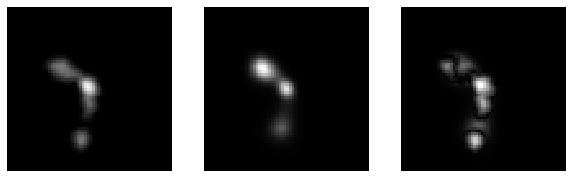

Clasify Train Epoch:  31 ( 99%)	C Acc: 0.5263	FR Acc: 0.5588	T Acc: 0.4125	B Acc: 0.5870	RX Acc: 0.5357
Train Epoch:  31 [139800/139800 (100%)]	Loss: 6.3614	R_Loss: 5.7377	DKL: 0.6237	AvgR 2.9604	Test Loss : 0.7807   Time : 258.52s
Beta : 1.0000328090065693
Clasify Train Epoch:  32 ( 99%)	C Acc: 0.5066	FR Acc: 0.4524	T Acc: 0.4605	B Acc: 0.6176	RX Acc: 0.4737
Train Epoch:  32 [139800/139800 (100%)]	Loss: 5.3293	R_Loss: 4.8190	DKL: 0.5103	AvgR 2.9593	Test Loss : 0.8121   Time : 256.08s
Beta : 1.000022966191575
Clasify Train Epoch:  33 ( 99%)	C Acc: 0.5132	FR Acc: 0.4889	T Acc: 0.5455	B Acc: 0.5625	RX Acc: 0.4667
Train Epoch:  33 [139800/139800 (100%)]	Loss: 9.4738	R_Loss: 8.6288	DKL: 0.8450	AvgR 2.9577	Test Loss : 0.7433   Time : 257.75s
Beta : 1.0000160762787211
Clasify Train Epoch:  34 ( 99%)	C Acc: 0.3553	FR Acc: 0.4839	T Acc: 0.3704	B Acc: 0.3478	RX Acc: 0.5000
Train Epoch:  34 [139800/139800 (100%)]	Loss: 9.8554	R_Loss: 9.1361	DKL: 0.7193	AvgR 2.9563	Test Loss : 0.7500   Time : 257

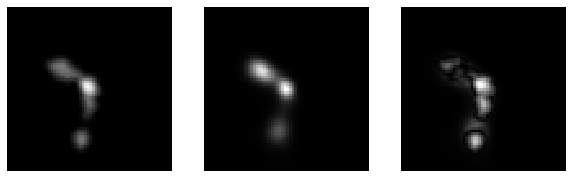

In [12]:
k = [1, 16, 'M', 32, 'M', 64, 64,'M', 64, 'M', 128, 128, 'M', 256]
model = VAE(lt_dim=8, k=k, n_classes=6).to(device)
# model = vae_models.VAE().to(device)
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=1E-5)
loss_fun = VAE_Loss()
criterion = nn.CrossEntropyLoss()

train_loss = []
test_loss  = []
beta = 8
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    classify_step_vae(model, device, data_loader_lrg_train, optimizer, epoch, loss_fun, criterion)
#     classify_step_vae(model, device, data_loader_lrg_train, optimizer, epoch, loss_fun, criterion)
    s, l = train_step_vae(model, device, data_loader_unlrg, optimizer, epoch, loss_fun=loss_fun, beta=beta)
    loss = test_step_vae(model, device, data_loader_lrg, loss_fun=loss_fun)
    
    train_loss.append(l)
    test_loss.append(loss)
    t = time.time() - start
    
    sys.stdout.write('{}\tAvgR {:.4f}\tTest Loss : {:4.4f}   Time : {:.2f}s\n'.format(s, l, loss, t))
    sys.stdout.flush()
    
    beta = beta **.7if beta > 1 else 1
    print('Beta : {}'.format(beta))
    if epoch % 10 == 0: 
        f, ax = plt.subplots(1, 3, figsize=(10, 5))
        o = model(sample[0].to(device))
        ax[0].imshow(sample[0][1][0], cmap='gray')
        ax[1].imshow(o[0][1][0].detach().cpu(), cmap='gray')
        diff = sample[0][1][0] - o[0][1][0].detach().cpu()
        ax[2].imshow(np.abs(diff), cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        plt.show()

In [30]:
# torch.save(model, 'SimpleBVAE_Class_all')

In [14]:
o = model(sample[0].to('cuda'))

In [15]:
target = Variable(sample[1], requires_grad=False).to(device)
criterion(o[1], target.to('cuda'))

tensor(2.6551, device='cuda:0', grad_fn=<NllLossBackward>)

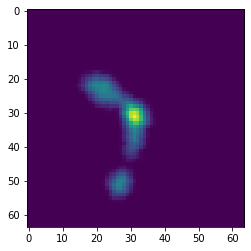

In [16]:
i = 1
plt.imshow(sample[0][i][0])

In [17]:
o = model(sample[0].to(device))

In [18]:
# o.shape

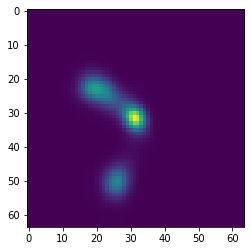

In [19]:
plt.imshow(o[0][i][0].detach().cpu())

In [20]:
# torch.save(model, 'SimpleVAE')

In [21]:
s = sample[0][i:i+1]

In [22]:
with torch.no_grad():
    e = model.encode(s.to(device))[0]

In [23]:
with torch.no_grad():
    d = model.decode(e)

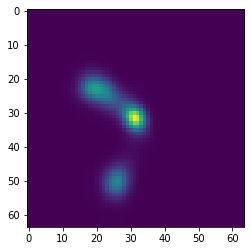

In [24]:
plt.imshow(d[0][0].cpu())

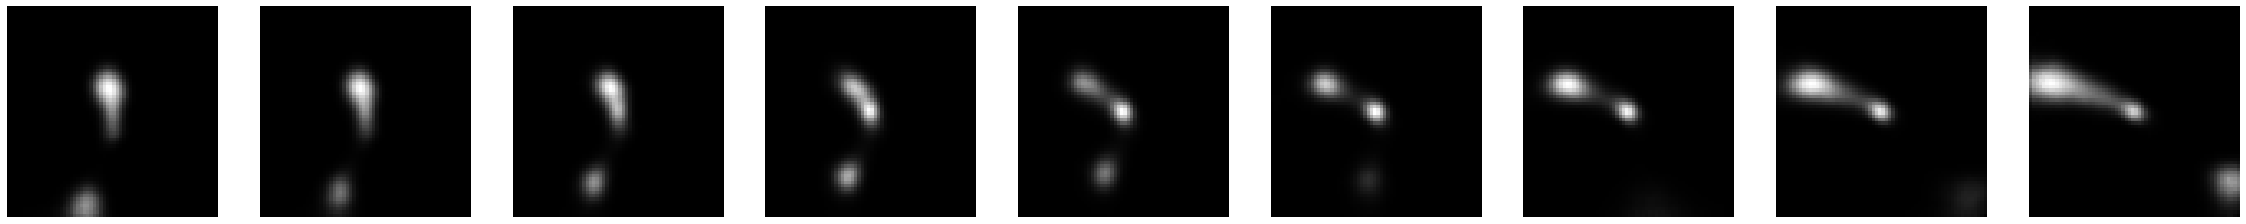

In [25]:
f, ax = plt.subplots(1, 9, figsize=(40, 20))

j = 7
for k, i in enumerate(np.arange(-2, 2.5, .5)):
    b = torch.tensor(e)
    b[0][j] = e[0][j] + 2*i
    with torch.no_grad():
        d = model.decode(b).cpu()[0][0]
    ax[k].imshow(d, cmap='gray')
    ax[k].axis('off')

In [26]:
e[0][6]

tensor(1.2712, device='cuda:0')

In [27]:
b = torch.tensor(e)

In [28]:
b[0][0] = 0

In [29]:
np.arange(-4, 4.5, 1)

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])